In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter as ff
plt.style.use('fivethirtyeight')

import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from datetime import datetime, timedelta

In [2]:
#creates connection to mongodb
client = pymongo.MongoClient()
db = client.tweeter

In [3]:
bernie_coll = db.bernie_tweets
joe_coll = db.joe_tweets
pete_coll = db.pete_tweets
warren_coll = db.warren_tweets
amy_coll = db.amy_tweets

In [4]:
#retrieved data from mongo into a dataframe
bernie_df = pd.DataFrame(list(bernie_coll.find()))
joe_df = pd.DataFrame(list(joe_coll.find()))
pete_df = pd.DataFrame(list(pete_coll.find()))
warren_df = pd.DataFrame(list(warren_coll.find()))
amy_df = pd.DataFrame(list(amy_coll.find()))

In [5]:
# b_df = bernie_df[~bernie_df['text'].isnull()]

In [6]:
# df = b_df.set_index('date')
# df.index = pd.to_datetime(df.index)
# df['year'] = df.index.year
# df['month'] = df.index.month
# df['wk_name'] = df.index.weekday_name

In [7]:
debates = pd.read_html('https://en.wikipedia.org/wiki/2020_Democratic_Party_presidential_debates')[2]

In [8]:
def sentiment_analyser(df):
    df = df[~df['text'].isnull()]
    df.loc[:,'text'] = df.loc[:,'text'].apply(lambda x: remove_url(x))
    n_df = df[~df['text'].isnull()]
    
    sentiment_objects = [TextBlob(tweet) for tweet in n_df['text']]
    # Create list of polarity valuesx and tweet text
    sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
    # Create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

    sent_df = n_df.merge(sentiment_df, left_on='text', right_on='tweet')
    
    sent_pol = []
    for x in sent_df['polarity']:
        if x == 0.000000:
            sent_pol.append('neutral')
        elif x > 0.000000:
            sent_pol.append('positive')
        elif x < 0.000000:
            sent_pol.append('negative')
    
    sent_df['sent_pol'] = sent_pol
    
    output_df = sent_df.set_index('date')
    output_df.index = pd.to_datetime(output_df.index)
    output_df['year'] = output_df.index.year
    output_df['month'] = output_df.index.month
    output_df['day'] = output_df.index.day
    output_df['wk_name'] = output_df.index.weekday_name
    
    return output_df

In [9]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [10]:
def plot_sentiment(df):
    #plot data
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot histogram of the polarity values
    sentiment_df.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                            0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                 ax=ax,
                 color="purple")

    plt.title(title)
    return plt.show()

In [11]:
def tweets_per_day(df):
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    result = df['wk_name'].value_counts().reindex(cats).reset_index().rename(columns={'index':'weekday', 'wk_name':'num_tweets'})
    return result

In [12]:
bernie_sentiment = sentiment_analyser(bernie_df)
joe_sentiment = sentiment_analyser(joe_df)
pete_sentiment = sentiment_analyser(pete_df)
warren_sentiment = sentiment_analyser(warren_df)
amy_sentiment = sentiment_analyser(amy_df)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



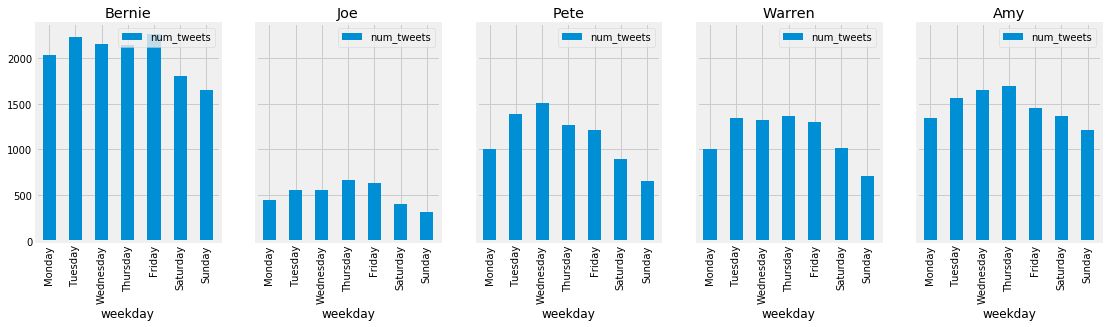

In [13]:
fig, ax = plt.subplots(1,5, figsize=(17,4), sharey=True, sharex=True)
tweets_per_day(bernie_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[0], title='Bernie')
tweets_per_day(joe_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[1], title='Joe')
tweets_per_day(pete_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[2], title='Pete')
tweets_per_day(warren_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[3], title='Warren')
tweets_per_day(amy_sentiment).plot(kind='bar',x='weekday', y='num_tweets', ax=ax[4], title='Amy')
plt.legend()
plt.show()

In [14]:
dnc_debates = pd.to_datetime(['June 26, 2019','June 27, 2019','July 30, 2019','July 31, 2019','September 12, 2019',
 'October 15, 2019','November 20, 2019','December 19, 2019','January 14, 2020',
 'February 7, 2020','February 19, 2020','February 25, 2020','March 15, 2020'])

In [15]:
def polarity_bydate(df, yr=None, mm=None, dd=None):
    '''
    creates a polarity graph based on dates selected. 
    '''
    try:
        if yr!=None and mm!=None and dd!=None:
            query = df[(df['year']==yr)&(df['month']==mm)&(df['day']==dd)]['polarity']
        elif yr!=None and mm!=None:
            query = df[(df['year']==yr)&(df['month']==mm)]['polarity']
        elif mm!=None and dd!=None:
            query = df[(df['month']==mm)&(df['day']==mm)]['polarity']
        elif yr!=None and dd!=None:
            query = df[(df['year']==yr)&(df['day']==mm)]['polarity']
        elif yr!=None:
            query = df[df['year']==yr]['polarity']
        elif mm!=None:
            query = df[df['month']==mm]['polarity']    
        elif dd!=None:
            query = df[df['day']==mm]['polarity']   

        #plot data
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot histogram of the polarity values
        query.hist(bins=[-1, -0.90, -.80, -.70, -.60, -0.50, -.40 ,-.30, -0.20,-.10, 
                                0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1],
                     ax=ax,
                     color="purple")

        plt.title("Sentiments from Tweets from Bernie")
        return plt.show()
    
    except:
        return print('please provide a year, month, or day to filter by')

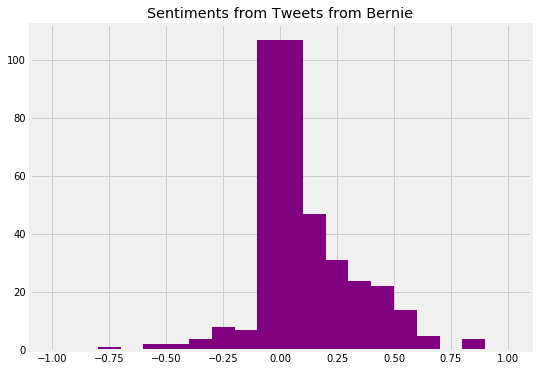

In [254]:
polarity_bydate(df=bernie_sentiment, yr=2020, mm=2)

In [39]:
def tweet_mention_hash_plot(df, rate='M'):
    df.resample(rate)[['text', 'mentions', 'hashtags']].count().plot()
    return plt.show()

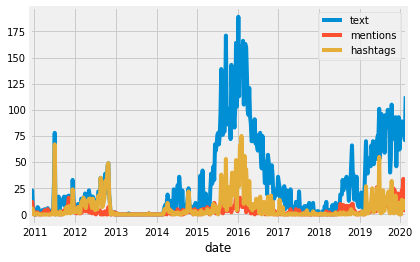

In [256]:
tweet_mention_hash_plot(bernie_sentiment, 'W')

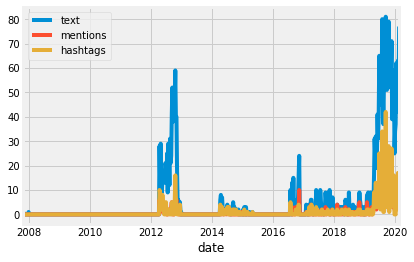

In [257]:
tweet_mention_hash_plot(joe_sentiment, 'W')

In [22]:
def data_filter(df, asof=None, dateadj=None):
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=dateadj))]
    
    result = df[['text', 'polarity', 'wk_name','favorites']]
    return result

In [23]:
bern_ann= pd.to_datetime('2/19/2019')
joe_ann= pd.to_datetime('4/25/2019')
pete_ann= pd.to_datetime('1/23/2019')
warren_ann= pd.to_datetime('12/31/2018')
amy_ann= pd.to_datetime('2/10/2019')

In [24]:
def polyplot(df, rate='M'):
    n_df = df[~df['text'].isnull()]
    show_df = n_df.set_index('date')
    show_df.index = pd.to_datetime(show_df.index)
    return show_df.resample(rate)['text'].count()

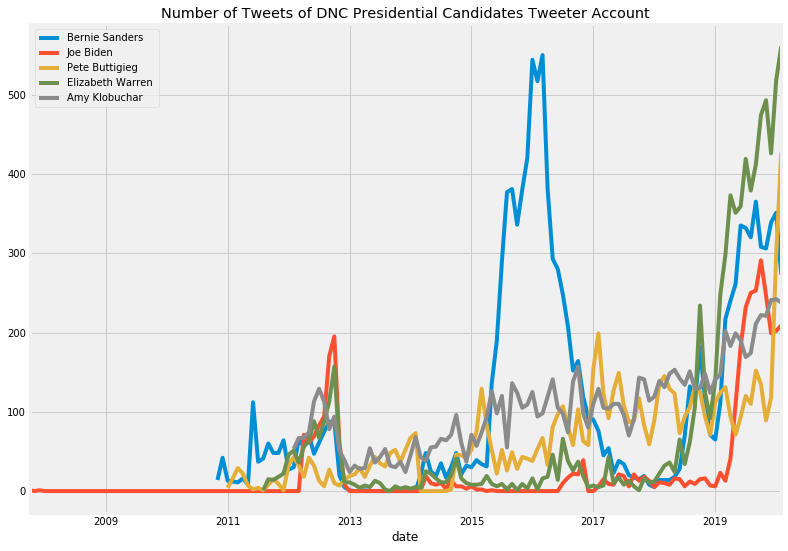

In [25]:
fig, ax = plt.subplots(figsize=(12,9))
polyplot(bernie_df).plot()
polyplot(joe_df).plot()
polyplot(pete_df).plot()
polyplot(warren_df).plot()
polyplot(amy_df).plot()
labels = ['Bernie Sanders', 'Joe Biden', 'Pete Buttigieg', 'Elizabeth Warren ', 'Amy Klobuchar']
plt.legend(labels)
plt.title('Number of Tweets of DNC Presidential Candidates Tweeter Account')
plt.show()

In [26]:
data = pd.concat([polyplot(bernie_df, rate='D'),polyplot(joe_df, rate='D'), 
                  polyplot(pete_df, rate='D'), polyplot(warren_df, rate='D'),
                  polyplot(amy_df, rate='D')], axis=1)

cols = ['bernie', 'joe', 'pete', 'warren', 'amy']
data.columns = cols

In [27]:
data.head()

bernie  joe  pete  warren  amy
date                                      
2007-10-24     NaN    1   NaN     NaN  NaN
2007-10-25     NaN    0   NaN     NaN  NaN
2007-10-26     NaN    0   NaN     NaN  NaN
2007-10-27     NaN    0   NaN     NaN  NaN
2007-10-28     NaN    0   NaN     NaN  NaN

In [28]:
def plot_trend(x, y):
    title = "{} Tweets Trends".format(y.capitalize())
    fig=px.line(data, x=x, y=y, title=title)
    return fig.show()

In [29]:
plot_trend(data.index, 'warren')
plot_trend(data.index, 'joe')

In [121]:
def retweet_fav_reply_plot(df, title, rate='M', debates=None, asof=None, figsize=(12,8)):
    if asof is not None:
        df = df[df.index > (asof - timedelta(days=7))]
    
    fig, ax = plt.subplots(figsize=figsize)
    df.resample(rate)[['retweets', 'favorites', 'replies']].mean().plot(ax=ax)
    ax.get_yaxis().set_major_formatter(ff(lambda x, p: format(int(x), ',')))
    ax.legend(fancybox=True, frameon=True, framealpha=1, shadow=True, borderpad=1, title='Twitter Interaction')
    
    ax.annotate('Candidate Announcement',
            xy=(asof, 1000),
            xycoords='data',
            xytext=(-50,-100),
            textcoords='offset points',
            arrowprops=dict(headwidth=5, width=2, color='#363d46', connectionstyle="angle3,angleA=0,angleB=-60"),
            fontsize=12)
    
    ax.axvline(asof, color='blue',alpha=0.4)
    for x in debates:
        ax.axvline(x, color='green',alpha=0.4, ls='--')
    plt.title(title)
    return plt.show()

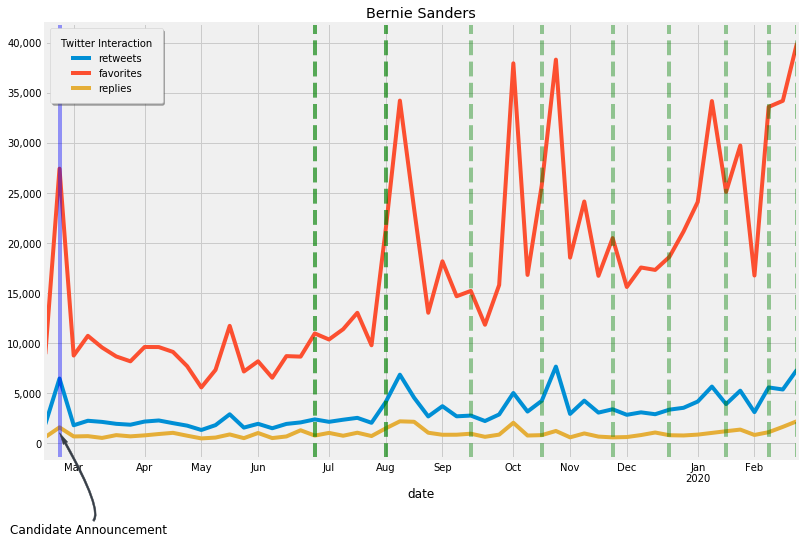

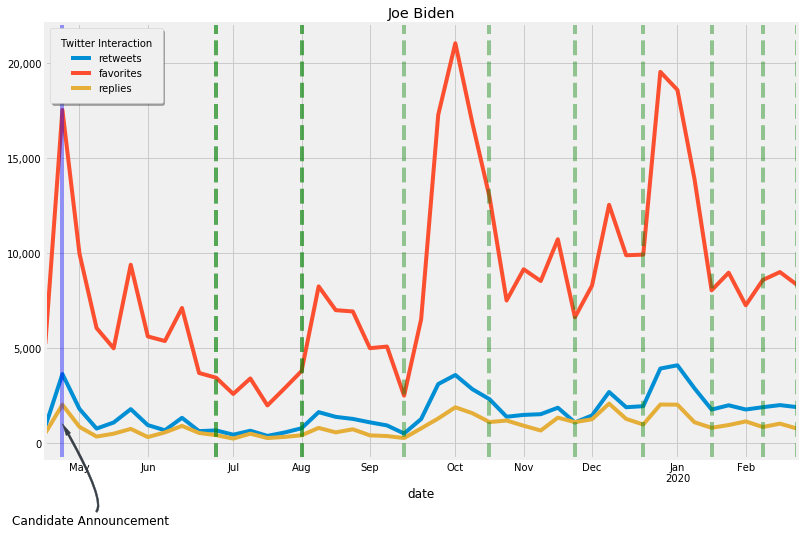

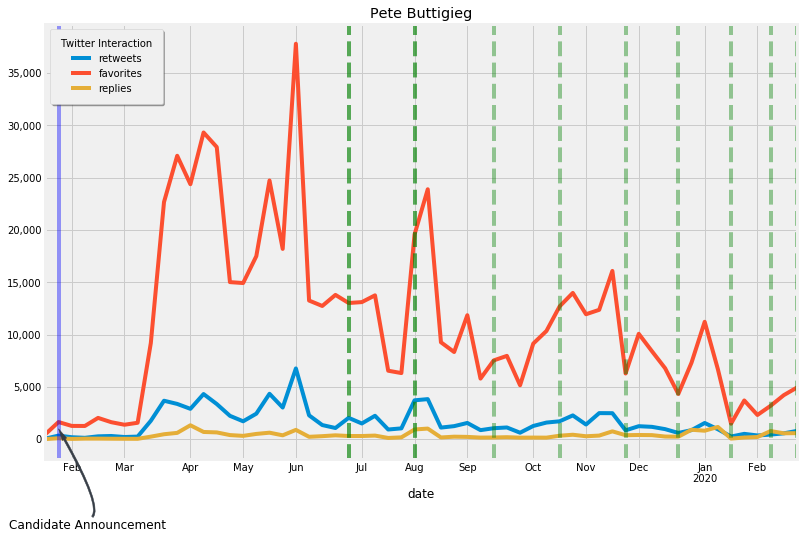

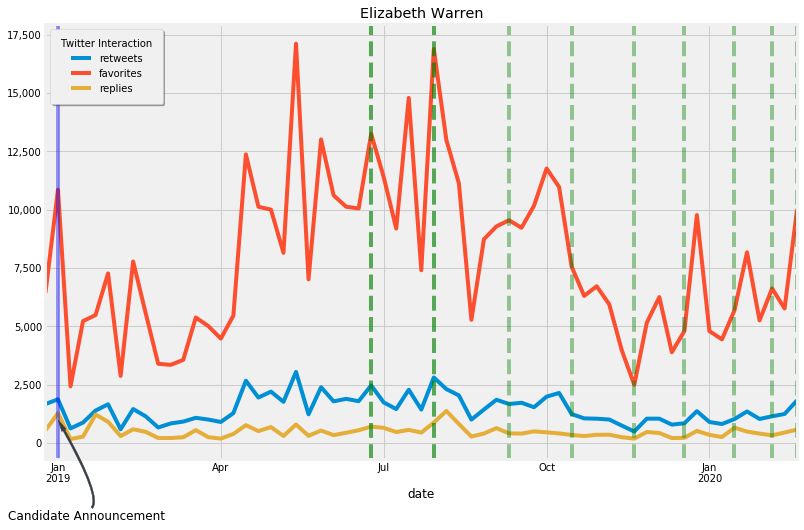

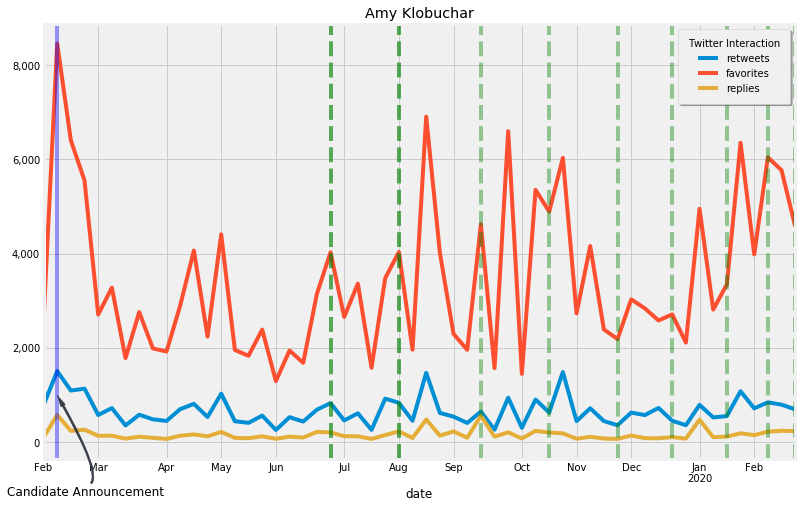

In [123]:
retweet_fav_reply_plot(bernie_sentiment, 'Bernie Sanders', rate='W', asof=bern_ann, debates=dnc_debates)
retweet_fav_reply_plot(joe_sentiment, 'Joe Biden', rate='W', asof=joe_ann, debates=dnc_debates)
retweet_fav_reply_plot(pete_sentiment, 'Pete Buttigieg', rate='W', asof=pete_ann, debates=dnc_debates)
retweet_fav_reply_plot(warren_sentiment, 'Elizabeth Warren', rate='W', asof=warren_ann, debates=dnc_debates)
retweet_fav_reply_plot(amy_sentiment, 'Amy Klobuchar', rate='W', asof=amy_ann, debates=dnc_debates)

In [124]:
def election_timeperiod(df, asof=None, days_adj=7):
    cols = ['polarity','retweets', 'favorites', 'replies']
    df = df[cols]
    return df[df.index > (asof - timedelta(days=days_adj))]

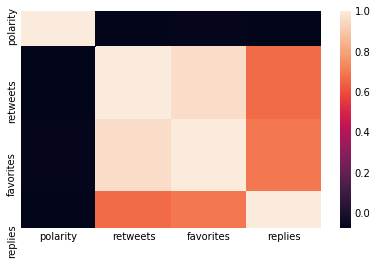

In [135]:
sns.heatmap(election_timeperiod(bernie_sentiment, bern_ann).corr())
plt.show()

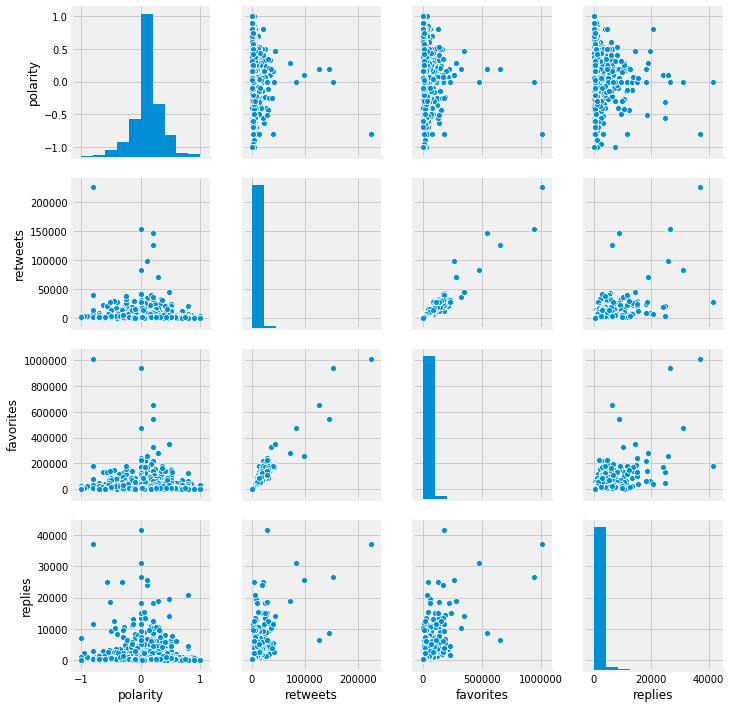

In [259]:
sns.pairplot(election_timeperiod(bernie_sentiment, bern_ann))
plt.show()

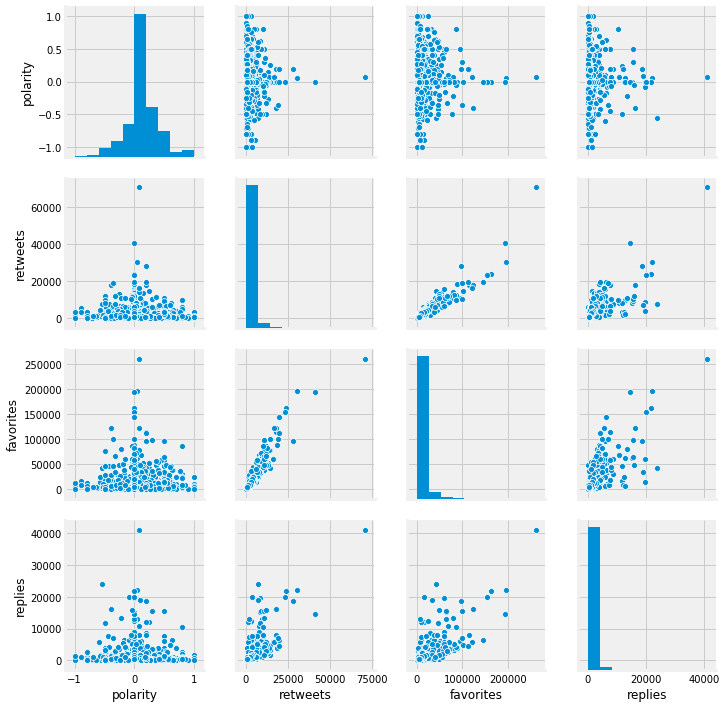

In [126]:
sns.pairplot(election_timeperiod(joe_sentiment, joe_ann))
plt.show()

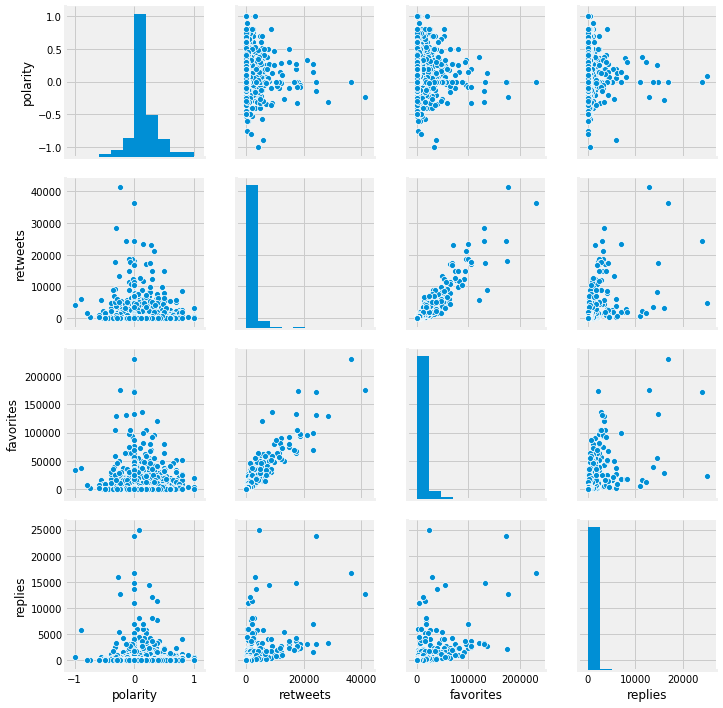

In [138]:
sns.pairplot(election_timeperiod(pete_sentiment, pete_ann))
plt.show()

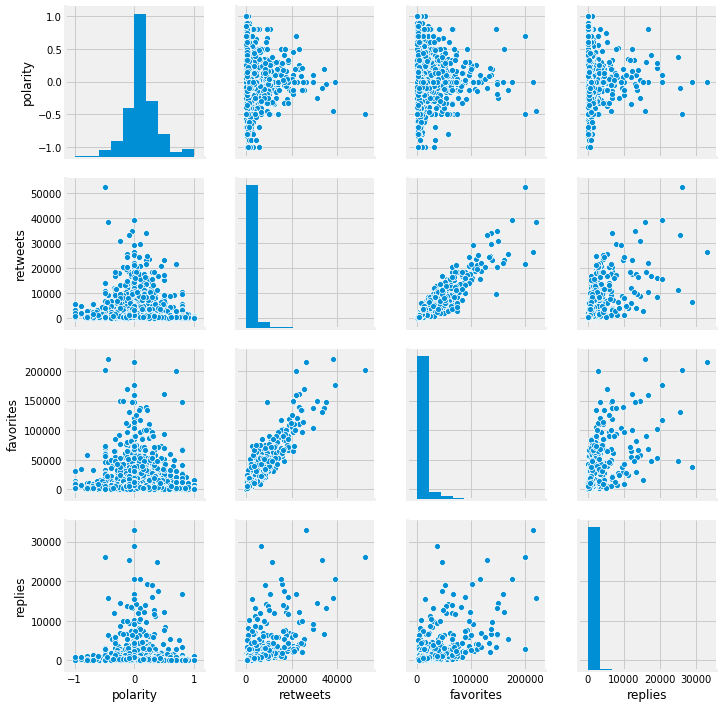

In [139]:
sns.pairplot(election_timeperiod(warren_sentiment, warren_ann))
plt.show()

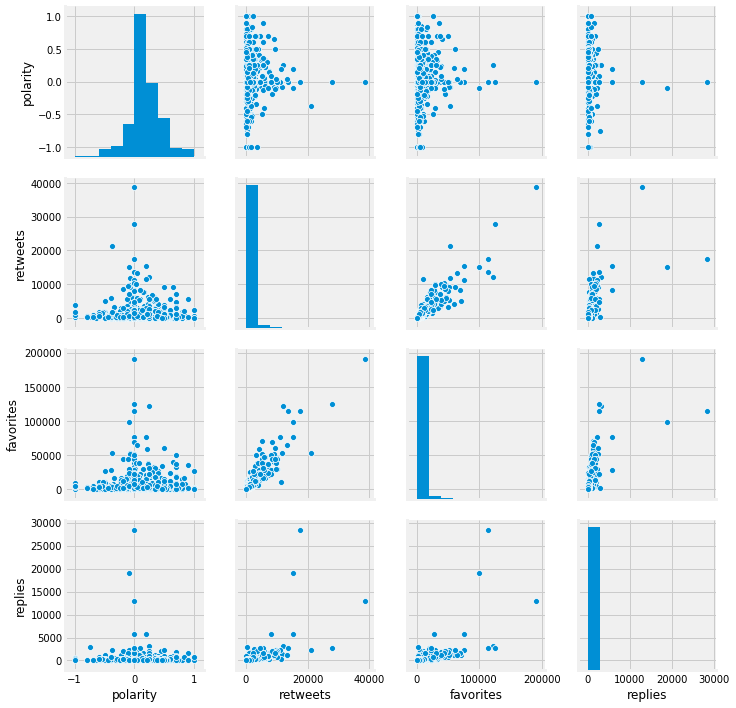

In [140]:
sns.pairplot(election_timeperiod(amy_sentiment, amy_ann))
plt.show()

In [142]:
def noun_phrase_wordlist(df):
    wordlist = pd.DataFrame()
    for t in df['text']:
        tx = TextBlob(t)
        l = list(tx.noun_phrases)
        if len(l)!=0:
            wordlist = wordlist.append(l)
    return wordlist

In [143]:
bern_wordlist = noun_phrase_wordlist(bernie_sentiment)
bern_allwords = bern_wordlist.groupby(0).size()

In [144]:
joe_wordlist = noun_phrase_wordlist(joe_sentiment)
joe_allwords = joe_wordlist.groupby(0).size()

In [145]:
pete_wordlist = noun_phrase_wordlist(pete_sentiment)
pete_allwords = pete_wordlist.groupby(0).size()

In [146]:
warren_wordlist = noun_phrase_wordlist(warren_sentiment)
warren_allwords = warren_wordlist.groupby(0).size()

In [147]:
amy_wordlist = noun_phrase_wordlist(amy_sentiment)
amy_allwords = amy_wordlist.groupby(0).size()

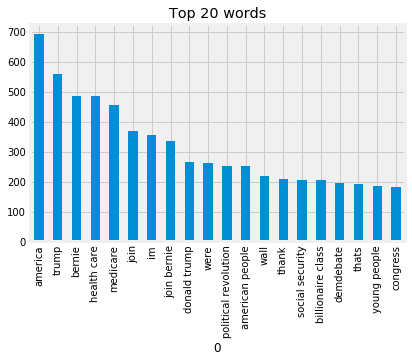

In [148]:
top20allword = bern_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

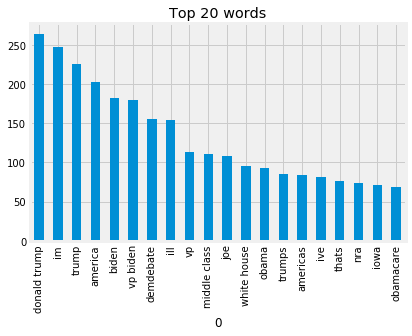

In [149]:
top20allword = joe_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

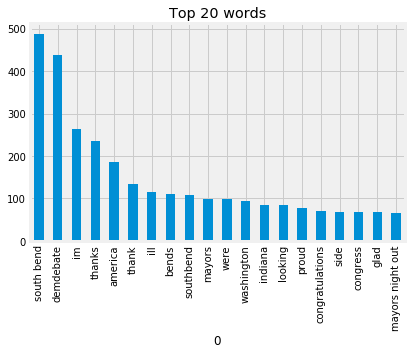

In [150]:
top20allword = pete_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

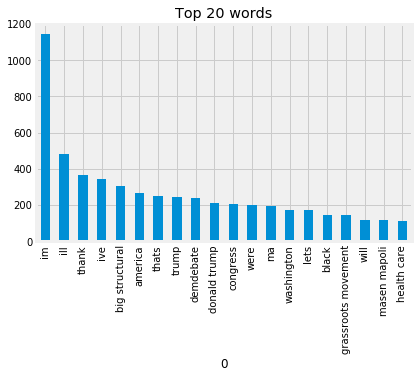

In [151]:
top20allword = warren_allwords.sort_values(0,ascending=False).head(20)
top20allword.plot(kind='bar',title='Top 20 words')
plt.show()

In [153]:
import pyLDAvis.gensim
import gensim
from gensim import corpora

In [252]:
def plot_polarity(df, asof=None):
    df = df['polarity']
    date = pd.datetime(asof)
    df = df[df.index > (asof)]
    return df.plot()

In [253]:
plot_polarity(bernie_sentiment, bern_ann)

TypeError: an integer is required (got type Timestamp)

In [251]:
bernie_sentiment.index

DatetimeIndex(['2020-02-23 23:08:28', '2020-02-23 23:04:57',
               '2020-02-23 22:34:47', '2020-02-23 22:34:46',
               '2020-02-23 20:20:37', '2020-02-23 19:31:24',
               '2020-02-23 19:26:23', '2020-02-23 16:27:14',
               '2020-02-23 15:57:24', '2020-02-23 15:11:20',
               ...
               '2010-11-30 15:54:03', '2010-11-24 15:00:41',
               '2010-11-22 16:44:42', '2010-11-19 18:44:03',
               '2010-11-19 18:32:31', '2010-11-19 18:25:30',
               '2010-11-17 21:50:00', '2010-11-17 21:49:06',
               '2010-11-17 20:48:02', '2010-11-17 20:46:06'],
              dtype='datetime64[ns]', name='date', length=14266, freq=None)

In [210]:
documents = [article.lower() for article in bernie_sentiment['text']]
# 2. Create a set of tokenized documents.
docs = [word_tokenize(content) for content in documents]
# 3. Strip out stop words from each tokenized document.
stop = set(stopwords.words('english'))
docs = [[word for word in words if word not in stop] for words in docs]

In [235]:
words = []
for i in range(0,len(docs)):
    freq = nltk.FreqDist(docs[i])
    words.extend(freq.items())


In [204]:
word_features = freq.keys()

dict_keys(['american', 'people', 'sick', 'tired', 'corrupt', 'administration', 'undermining', 'democracy', 'government', 'based', 'greed', 'lies', 'time', 'racial', 'social', 'economic', 'environmental', 'justice'])

In [166]:
porter = PorterStemmer()
docs_porter = [[porter.stem(word) for word in words] for words in docs]

In [193]:
dictionary.filter_extremes(no_below=5, keep_n=50000)

In [195]:
# Create corpus
bernie_sentiment['lower_txt'] = [x.lower() for x in bernie_sentiment['text']]
corpus = [dictionary.doc2bow(text) for text in bernie_sentiment['lower_txt'].str.split(',')]

In [196]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 6,
id2word =dictionary, passes=50)

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:821: RuntimeWarning:

divide by zero encountered in double_scalars



In [199]:
# Print the three topics from the model with top words
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.002*"together" + 0.002*"good" + 0.002*"Vermont" + 0.002*"family" + 0.002*"hour" + 0.002*"living" + 0.002*"richest" + 0.002*"pay" + 0.002*"her" + 0.002*"expand"')
(1, '0.002*"together" + 0.002*"good" + 0.002*"Vermont" + 0.002*"family" + 0.002*"hour" + 0.002*"living" + 0.002*"richest" + 0.002*"pay" + 0.002*"her" + 0.002*"expand"')
(2, '0.002*"together" + 0.002*"good" + 0.002*"Vermont" + 0.002*"family" + 0.002*"hour" + 0.002*"living" + 0.002*"richest" + 0.002*"pay" + 0.002*"her" + 0.002*"expand"')
(3, '0.013*"together" + 0.002*"good" + 0.002*"Vermont" + 0.002*"family" + 0.002*"hour" + 0.002*"living" + 0.002*"richest" + 0.002*"pay" + 0.002*"her" + 0.002*"expand"')
(4, '0.009*"good" + 0.002*"together" + 0.002*"Vermont" + 0.002*"family" + 0.002*"hour" + 0.002*"living" + 0.002*"richest" + 0.002*"pay" + 0.002*"her" + 0.002*"expand"')
(5, '0.002*"together" + 0.002*"good" + 0.002*"Vermont" + 0.002*"family" + 0.002*"hour" + 0.002*"living" + 0.002*"richest" + 0.002*"pay" + 0.002*"her" + 0.0

In [16]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

#########RandomForestClassifier
# Fitting classifier to the Training set
from sklearn.ensemble import RandomForestRegressor
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, r2_score
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer

In [41]:
bern_features = data_filter(bernie_sentiment, asof=bern_ann, dateadj=7)

In [42]:
bern_features.head()

text  \
date                                                                     
2020-02-23 23:08:28  We won the popular vote in Iowa we won the New...   
2020-02-23 23:04:57  This campaign has the momentum to win but we c...   
2020-02-23 22:34:47  As president I will support the rights of both...   
2020-02-23 22:34:46  The Israeli people have the right to live in p...   
2020-02-23 20:20:37  Trump and his friends think theyre going to wi...   

                     polarity wk_name  favorites  
date                                              
2020-02-23 23:08:28  0.318182  Sunday      23609  
2020-02-23 23:04:57  0.408333  Sunday       4533  
2020-02-23 22:34:47  0.000000  Sunday      44742  
2020-02-23 22:34:46  0.140693  Sunday      97230  
2020-02-23 20:20:37  0.470000  Sunday      63002

In [43]:
corpus = []
for i in range(len(bern_features['text'])):
    review = re.sub('[^a-zA-Z]',' ',bern_features['text'][i])
    review = review.lower()
    review = review.split() #convert into list
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
bern_features['corpus'] = corpus
X_ = bern_features[['corpus', 'polarity']]

In [ ]:
X_sw = tfidf.fit_transform(corpus_sw).toarray()

In [ ]:
X_f = X_.reset_index().merge(pd.DataFrame(tfidf.fit_transform(corpus).toarray()), left_index=True, right_index=True)

In [44]:
ngram_vec = CountVectorizer(ngram_range=(3,3))
X_counts = ngram_vec.fit_transform(corpus)

In [104]:
X_example = tfidf.fit_transform(['hello guys great day']).toarray()

In [52]:
X_counts.shape                                                                    
print(ngram_vec.get_feature_names())                                                                              

['aapi commun fulli', 'aapi sister brother', 'aarondfordnv go make', 'aaupaft rutger professor', 'ab ban privat', 'ab help driver', 'abandon coal worker', 'abandon commun depend', 'abandon commun left', 'abandon denigr stand', 'abandon everyth rebuild', 'abandon fossil fuel', 'abandon labor movement', 'abandon puerto rico', 'abandon senior everi', 'abdic respons today', 'abdulsamad endors togeth', 'abhorr human right', 'abil blow thing', 'abil creat power', 'abil get health', 'abil get involv', 'abil hear luxuri', 'abil hear shouldnt', 'abil nation address', 'abil organ collect', 'abil see abil', 'abl accept unit', 'abl accomplish invest', 'abl accomplish white', 'abl accumul money', 'abl afford care', 'abl afford health', 'abl afford outrag', 'abl attend colleg', 'abl attend excel', 'abl buy elect', 'abl charg whatev', 'abl close philadelphia', 'abl control polit', 'abl creat real', 'abl defeat berni', 'abl didnt cancelstudentdebt', 'abl end corpor', 'abl fire worker', 'abl fulfil vis

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_counts.toarray(), y, test_size = 0.20, random_state = 0)

In [101]:
X_counts

<3807x49092 sparse matrix of type '<class 'numpy.int64'>'
	with 59283 stored elements in Compressed Sparse Row format>

In [48]:
regressor_ngram = RandomForestRegressor(n_estimators=100, criterion='mse', max_features=0.1)

In [49]:
regressor_ngram.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
y_pred_ngram = regressor_ngram.predict(X_test)

In [238]:
regressor.fit_transform(X_example)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sw, y, test_size = 0.20, random_state = 0)

In [46]:
y= bern_features['favorites'].values

In [ ]:
len(y)

In [81]:
#bag of words model
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(corpus).toarray()

In [85]:
ngrams_tf = TfidfVectorizer(ngram_range=(2,2), analyzer=corpus)

In [80]:
X.shape

(3807, 4975)

distribution of tweet counts
try not removing stopwords
bygrams
doc freq (decrease size of corpus )


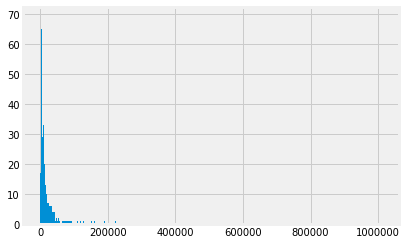

In [89]:
plt.hist(y_test, bins=1000)
plt.show()

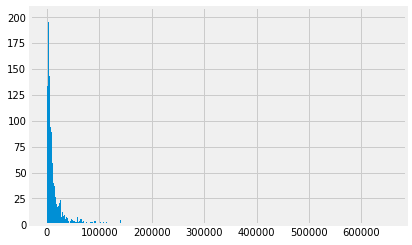

In [90]:
plt.hist(y_train, bins=1000)
plt.show()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [54]:
regressor = RandomForestRegressor(n_estimators=500)
regressor2 = RandomForestRegressor(n_estimators=300, min_samples_split=3, )
regressor3 = RandomForestRegressor(n_estimators=500, n_jobs=-1, min_samples_leaf=3)
regressor_sw = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [57]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
regressor_sw.fit(X_train,y_train)

In [ ]:
regressor2.fit(X_train,y_train)

In [58]:
y_pred = regressor.predict(X_test)

In [ ]:
y_pred2 = regressor2.predict(X_test)

In [ ]:
y_pred3 = regressor3.predict(X_test)

In [ ]:
y_pred_sw = regressor_sw.predict(X_test)

In [70]:
print('Mean Squared Log Error:', round(metrics.mean_squared_log_error(y_test, y_pred),2))
print('Mean Squared Log Error:', round(metrics.mean_squared_log_error(y_test, y_pred_ngram),2))

Mean Squared Log Error: 1.18
Mean Squared Log Error: 3.45


In [73]:
mape = 100*(metrics.mean_absolute_error(y_test, y_pred)/y_test)

In [68]:
regressor.score(X_train, y_train)

0.8259039319951473

In [76]:
from sklearn.model_selection import cross_val_score

In [ ]:
Mean Absolute Error: 16438.35
reg2 = 0.12953373349448272

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
errors = metrics.mean_absolute_error(y_test, y_pred)
# print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test, y_pred))

In [ ]:
importance = regressor.feature_importances_

In [ ]:
regressor.score(X_train, y_train)

In [ ]:
regressor.score(X_test, y_test)

In [ ]:
std = np.std([regressor.feature_importances_ for tree in regressor.estimators_],
             axis=0)
indices = np.argsort(importance)[::-1]

In [ ]:
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
bern_f = pd.get_dummies(bern_features, columns=['wk_name'], drop_first=True)

In [ ]:
df = bern_f.iloc[:,1:]

In [ ]:
y = df.pop('favorites')
X = df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(X_train,y_train)

In [ ]:
regressor.score(X_train, y_train)

In [ ]:
regressor.score(X_test, y_test)